In [16]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split


In [19]:


# Set paths
metadata_file = r'new_metadata.csv'
audio_dir = r'dataset/ESC-50-master/audio/'

# Load metadata
metadata_df = pd.read_csv(metadata_file)
#print(metadata_df)


In [20]:

# Filter categories for audio classifier (e.g., Helicopter, Chainsaw, etc.)
categories = ['helicopter', 'chainsaw', 'siren', 'car_horn', 'engine', 'train', 'church_bells', 'airplane', 'fireworks', 'hand_saw']
filtered_df = metadata_df[metadata_df['category'].isin(categories)]

# Define function to extract MFCC features from an audio file
def extract_mfcc(file_path, n_mfcc=13, hop_length=512):
    y, sr = librosa.load(file_path, sr=None)  # Load the audio file
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length)  # Extract MFCC
    return mfcc



In [21]:

# Preprocess the data
X = []
y = []

# Iterate through the filtered dataset and extract features and labels
for idx, row in filtered_df.iterrows():
    file_path = os.path.join(audio_dir, row['category'], row['filename'])
    if os.path.exists(file_path):
        # Extract MFCC features
        mfcc = extract_mfcc(file_path)
        X.append(mfcc)
        y.append(row['category'])


In [22]:

# Convert to numpy arrays
X = np.array([np.mean(mfcc, axis=1) for mfcc in X])  # Take mean across time axis
y = np.array([categories.index(category) for category in y])  # Convert categories to integers


In [23]:
#print(len(X))  # Should show the number of sequences
#print(X[:5])    # Print the first 5 sequences (or inspect a few elements)


400
[[-5.33568726e+02  1.82440979e+02 -2.11755466e+00  8.50080776e+00
   1.55925977e+00  2.19778538e+00  4.15884644e-01 -1.93029857e+00
   2.16634750e+00 -3.02898854e-01 -3.64740640e-02  1.15669765e-01
   1.23329926e+00]
 [-4.64291473e+02  1.30576950e+02  2.19855175e+01  8.46765041e+00
   1.70591819e+00  5.93445957e-01  1.91420221e+00 -5.75630784e-01
   1.35183668e+00  9.64682817e-01 -1.93961442e-01 -1.39149457e-01
   2.82033682e-01]
 [-4.71927429e+02  1.39217651e+02  3.14949512e+01 -5.44543791e+00
  -2.99933863e+00  6.42351866e+00  5.36778402e+00  6.01289213e-01
  -8.07166815e-01  9.07666206e-01  1.41873360e+00  2.75453091e-01
   6.33128107e-01]
 [-4.84623993e+02  1.37978775e+02  5.44633675e+01  5.36038971e+00
  -2.46818423e+00  3.53266382e+00  6.00749302e+00  3.21424437e+00
  -6.51149094e-01 -1.86527562e+00 -1.05244672e+00  1.25521988e-01
   9.79418814e-01]
 [-1.27490707e+02  1.66818558e+02 -6.71186981e+01  4.19572296e+01
  -3.54565392e+01  1.53109193e+00 -1.60132408e+01 -8.66732311e

In [24]:

# Pad sequences to have the same length
X = tf.keras.preprocessing.sequence.pad_sequences(X, padding='post')


In [27]:

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize data
X_train = X_train.astype('float32') / np.max(X_train)
X_val = X_val.astype('float32') / np.max(X_val)

# Convert labels to categorical (one-hot encoding)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(categories))
y_val = tf.keras.utils.to_categorical(y_val, num_classes=len(categories))
# Reshape X_train to (num_samples, num_features, 1) to make it compatible with 1D CNN
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))



In [43]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(128, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(256, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(len(categories), activation='softmax')
])


In [47]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [48]:

from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32, callbacks=[early_stopping])


# Step 6: Evaluate the Model
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")


Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.0918 - loss: 2.3020 - val_accuracy: 0.0875 - val_loss: 2.2952
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1603 - loss: 2.2680 - val_accuracy: 0.0875 - val_loss: 2.2766
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1746 - loss: 2.2423 - val_accuracy: 0.1250 - val_loss: 2.2332
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2135 - loss: 2.1789 - val_accuracy: 0.1250 - val_loss: 2.1703
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2172 - loss: 2.0919 - val_accuracy: 0.1625 - val_loss: 2.0842
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2761 - loss: 2.0634 - val_accuracy: 0.1625 - val_loss: 2.0255
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2795 - loss: 1.9951 - val_accuracy: 0.2375 - val_loss: 1.9095
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3549 - loss: 1.8420 - val_accuracy: 0.4000 - va

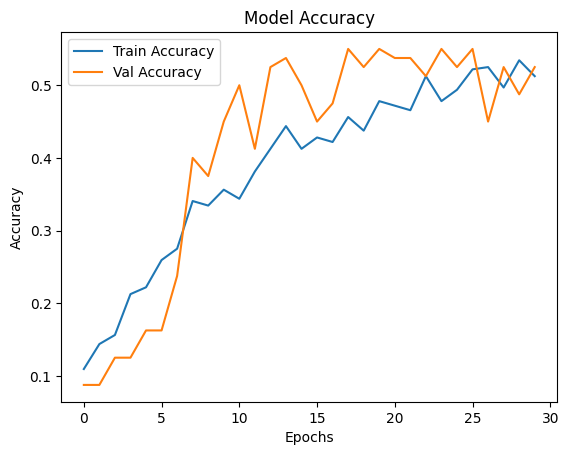

In [53]:

# Step 7: Save the Model
model.save('audio_classifier_model.h5')

# Optionally, visualize training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
